<a href="https://colab.research.google.com/github/shukubota/colabs/blob/main/videoconvert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os
from google.colab import drive
from google.colab.patches import cv2_imshow

def extract_frames(video_path, output_folder, max_frames=5):
    # Google Driveをマウント
    drive.mount('/content/drive')

    # ビデオファイルを開く
    video = cv2.VideoCapture(video_path)

    # 出力フォルダが存在しない場合は作成
    full_output_path = f"/content/drive/MyDrive/{output_folder}"
    if not os.path.exists(full_output_path):
        os.makedirs(full_output_path)

    # フレームカウンタ
    frame_count = 0

    while frame_count < max_frames:
        # フレームを読み込む
        success, frame = video.read()

        if not success:
            break

        # フレームを保存
        output_path = os.path.join(full_output_path, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(output_path, frame)

        # フレームを表示（Colab用）
        cv2_imshow(frame)

        frame_count += 1

    # ビデオファイルを閉じる
    video.release()

    print(f"合計 {frame_count} フレームを抽出しました。")
    print(f"フレームは {full_output_path} に保存されました。")


Mounted at /content/drive


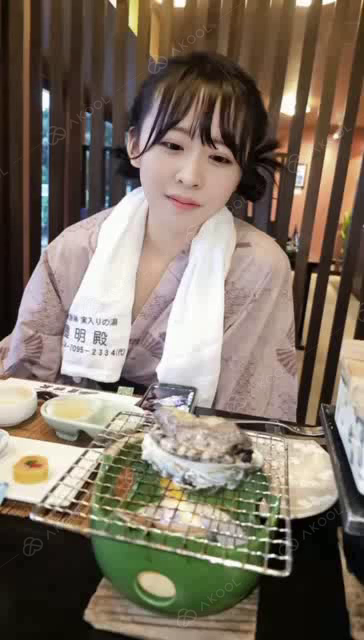

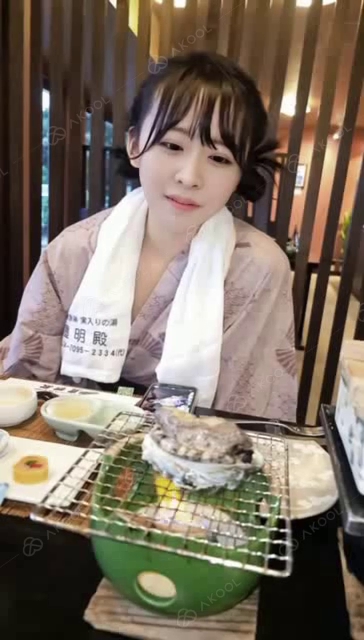

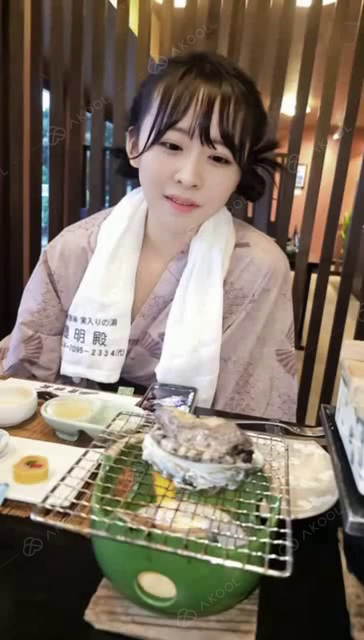

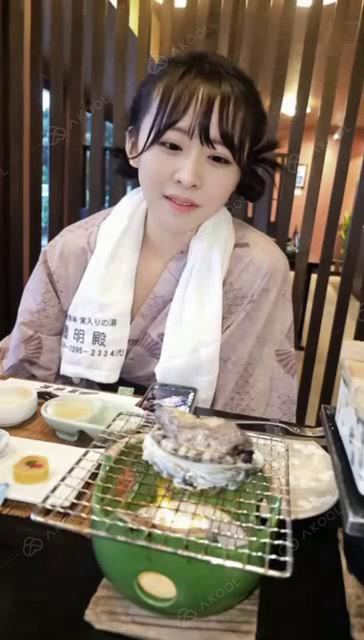

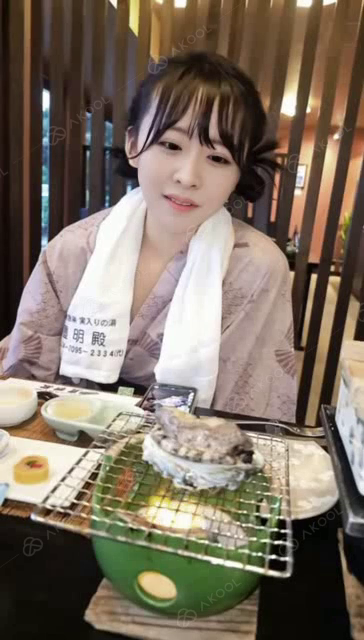

合計 5 フレームを抽出しました。
フレームは /content/drive/MyDrive/output_frames に保存されました。


In [ ]:
video_path = "/content/drive/MyDrive/videoconvert/raw.mov"
output_folder = "output_frames"  # Google Drive上に作成されるフォルダ名
max_frames = 5  # 抽出するフレームの最大数

extract_frames(video_path, output_folder, max_frames)